### import 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, ConcatDataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as Fs
from torchinfo import summary
from PIL import Image
from skimage import io, color, transform as tr
from pathlib import Path
import torchvision.models as models
from sklearn.metrics import r2_score, mean_squared_error
from torch.nn import DataParallel
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


### load dataset

In [3]:
class EarLandmarkDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = Path(directory)
        self.transform = transform
        self.img_names = [f.name for f in self.directory.glob('*.png')]
        self.pts_names = [f.name for f in self.directory.glob('*.pts')]
        print(f'Found {len(self.img_names)} images in {directory}')
        print(f'Found {len(self.pts_names)} points files in {directory}')

    def __len__(self):
        return len(self.img_names)
      
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.directory / self.img_names[idx]
        image = io.imread(img_name)
        
        # Check if image has three channels
        if image.ndim < 3 or image.shape[2] < 3:
            # Convert grayscale or single-channel images to RGB
            image = color.gray2rgb(image)
        
        pts_name = self.directory / self.pts_names[idx]
        with open(pts_name, 'r') as file:
            landmarks = file.readlines()[3:-1] # Skip first 3 lines and last line
            
        landmarks = [p.replace('\n', '')for p in landmarks] # Remove new line characters
        landmarks = [p.split(' ') for p in landmarks] # Split into x and y coordinates by space
        landmarks = np.array([landmarks], dtype=np.float32).reshape(-1, 2)
        
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
      
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = tr.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}
      
class ToTensor(object):
    def __init__(self, normalize=True):
        self.normalize = normalize
        
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))
        if self.normalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            mean = mean[:, np.newaxis, np.newaxis]
            std = std[:, np.newaxis, np.newaxis]
            image = (image - mean) / std
            
        return {'image': torch.from_numpy(image).to(torch.float32), 'landmarks': torch.from_numpy(landmarks).to(torch.float32)}
      
class HorizonalFlip(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = np.fliplr(image)
        landmarks[:, 0] = image.shape[1] - landmarks[:, 0]
        return {'image': image, 'landmarks': landmarks}

class VerticalFlip(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = np.flipud(image)
        landmarks[:, 1] = image.shape[0] - landmarks[:, 1]
        return {'image': image, 'landmarks': landmarks}
    
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        # Find the bounding box of the landmarks
        min_x, min_y = np.min(landmarks, axis=0)
        max_x, max_y = np.max(landmarks, axis=0)
        ear_center_x = (min_x + max_x) / 2
        ear_center_y = (min_y + max_y) / 2

        # Calculate the crop region based on the ear center
        top = max(0, int(ear_center_y - new_h / 2))
        left = max(0, int(ear_center_x - new_w / 2))
        bottom = min(h, top + new_h)
        right = min(w, left + new_w)

        # Crop the image
        image = image[top:bottom, left:right]

        # Adjust landmark coordinates relative to the new cropped image
        landmarks[:, 0] -= left
        landmarks[:, 1] -= top

        return {'image': image, 'landmarks': landmarks}


### preprocess the dataset

In [4]:
BATCH_SIZE = 16

# original image
transform = transforms.Compose([
    Rescale((224, 224)),
    ToTensor()
])

# vertical flip original
vertical_transform = transforms.Compose([
    VerticalFlip(),
    Rescale((224, 224)),
    ToTensor(),
])

# horitzonal flip original
horizonal_transform = transforms.Compose([
    HorizonalFlip(),
    Rescale((224, 224)),
    ToTensor()
])

# crop original image
crop_transform = transforms.Compose([
    RandomCrop(640),
    Rescale((224, 224)),
    ToTensor()
])

# vertical flip crop
crop_vertical_transform = transforms.Compose([
    RandomCrop(640),
    VerticalFlip(),
    Rescale((224, 224)),
    ToTensor(),
])

# horitzonal flip crop
crop_horizonal_transform = transforms.Compose([
    RandomCrop(640),
    HorizonalFlip(),
    Rescale((224, 224)),
    ToTensor()
])


train_dir = './CollectionA/train'
test_dir = './CollectionA/test'

train_data1 = EarLandmarkDataset(train_dir, transform=transform)
train_data2 = EarLandmarkDataset(train_dir, transform=vertical_transform)
train_data3 = EarLandmarkDataset(train_dir, transform=horizonal_transform)
train_data4 = EarLandmarkDataset(train_dir, transform=crop_transform)
train_data5 = EarLandmarkDataset(train_dir, transform=crop_vertical_transform)
train_data6 = EarLandmarkDataset(train_dir, transform=crop_horizonal_transform)

train_data = ConcatDataset([train_data1, train_data2, train_data3, train_data4, train_data5, train_data6])
test_data = EarLandmarkDataset(test_dir, transform=transform)

test_size = len(test_data) // 2
val_size = len(test_data) - test_size

test_data, val_data = random_split(test_data, [test_size, val_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=5)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=5)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=5)

print(f'Train: {len(train_data)}, Test: {len(test_data)}, Val: {len(val_data)}')

Found 500 images in ./CollectionA/train
Found 500 points files in ./CollectionA/train
Found 500 images in ./CollectionA/train
Found 500 points files in ./CollectionA/train
Found 500 images in ./CollectionA/train
Found 500 points files in ./CollectionA/train
Found 500 images in ./CollectionA/train
Found 500 points files in ./CollectionA/train
Found 500 images in ./CollectionA/train
Found 500 points files in ./CollectionA/train
Found 500 images in ./CollectionA/train
Found 500 points files in ./CollectionA/train
Found 105 images in ./CollectionA/test
Found 105 points files in ./CollectionA/test
Train: 3000, Test: 52, Val: 53


In [5]:
print('Train data:', train_data[0].get('image'))

Train data: tensor([[[-2.0002, -1.9760, -1.9225,  ..., -1.9771, -2.0520, -2.0207],
         [-2.0210, -1.9789, -1.9564,  ..., -2.0016, -2.0511, -2.0673],
         [-2.0572, -1.9932, -1.9532,  ..., -2.0141, -2.0323, -2.0451],
         ...,
         [-2.0010, -1.9648, -1.9350,  ..., -1.9666, -1.8658, -1.9297],
         [-1.9967, -1.9671, -1.9522,  ..., -1.8924, -1.9227, -2.0531],
         [-1.9796, -1.9265, -1.9124,  ..., -1.8887, -2.0287, -1.9308]],

        [[-1.9168, -1.9304, -1.9272,  ..., -1.6464, -1.7129, -1.6738],
         [-1.9381, -1.9333, -1.9613,  ..., -1.6715, -1.7129, -1.7230],
         [-1.9751, -1.9477, -1.9566,  ..., -1.6850, -1.7060, -1.7258],
         ...,
         [-1.9162, -1.8792, -1.8509,  ..., -1.6987, -1.5055, -1.5770],
         [-1.9118, -1.8816, -1.8679,  ..., -1.5903, -1.4993, -1.7497],
         [-1.8943, -1.8401, -1.8272,  ..., -1.5886, -1.6967, -1.6871]],

        [[-1.6505, -1.6470, -1.6313,  ..., -1.2319, -1.3498, -1.3511],
         [-1.6717, -1.6500, -1.66

Sample 0:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


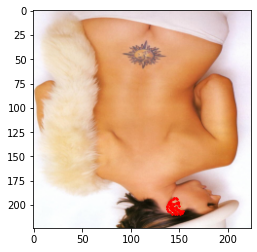

Sample 1:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


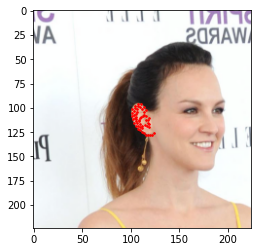

Sample 2:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


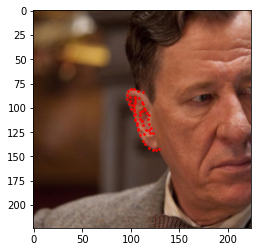

Sample 3:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


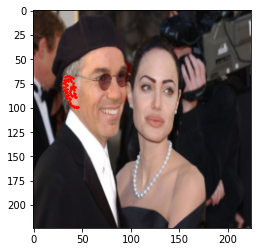

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i, sample in enumerate(train_loader):
    print(f'Sample {i}:')
    print('Image shape:', sample['image'].shape)
    print('Landmarks shape:', sample['landmarks'].shape)
    
    # Undo normalization for the image
    image = sample['image'] 
    image = (image * std[:, None, None]) + mean[:, None, None]
    
    image_pil = Fs.to_pil_image(image[0])
    plt.imshow(image_pil)
    plt.scatter(sample['landmarks'][0][:, 0], sample['landmarks'][0][:, 1], s=10, marker='.', c='r')
    plt.show()
    if i == 3:
        break
    

### build the base model with convolutional block attention module

In [7]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size = 7):
        super().__init__()

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)

        out = torch.cat([avg_pool, max_pool], dim=1)
        out = self.conv(out)
        attention = self.sigmoid(out)
        return attention * x

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, input, reduction_ratio=16):
        super().__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(input, input // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(input // reduction_ratio, input, 1, bias=False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))

        out = avg_out + max_out
        attention = self.sigmoid(out)
        return attention * x

In [9]:
class CBAM(nn.Module):
    def __init__(self, input):
        super().__init__()
        self.channel_attention = ChannelAttention(input)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        out = self.channel_attention(x)
        out = self.spatial_attention(out)
        return out

In [10]:
class ResnetWithCBAM(nn.Module):
    def __init__(self, num_classes, dropout = 0):
        super().__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.cbam = CBAM(512)
        self.dropout = nn.Dropout(dropout)

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes*2)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.cbam(x)

        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.resnet.fc(x)
        return x


### train/setup loop

In [11]:
# training loop
def train(model, num_epochs, criterion, optimizer, scheduler=None):
    result = {
        "train_loss": [],
        "train_r2": [],
        "val_loss": [],
        "val_r2": [],
    }

    tolerance = 10
    best_loss = None
    for epoch in range(1,num_epochs+1):
        sample = 0
        total_loss = 0
        y_true = torch.tensor([]).to(device)
        output = torch.tensor([]).to(device)
        # training loop
        model.train()
        for batch in train_loader:
            inputs = batch["image"]
            targets = batch["landmarks"]
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            # forward pass
            y_pred = model(inputs)
            # cacluate loss
            y_pred = y_pred.flatten()
            targets = targets.flatten()
            loss = criterion(y_pred, targets)
            
            y_true = torch.cat((y_true, targets))
            output = torch.cat((output, y_pred))
            total_loss += loss.item()
            
            # backward pass
            loss.backward()
            optimizer.step()
            sample += 1

        r2 = r2_score(y_true.detach().cpu().numpy().reshape(y_true.shape[0], -1), output.detach().cpu().numpy().reshape(output.shape[0], -1))

        result["train_r2"].append(r2)
        result["train_loss"].append(total_loss/sample)
        print(f"Epoch {epoch}/{num_epochs}: train loss: {total_loss/sample}, train r2: {r2}")

        # val loop
        sample = 0
        total_loss = 0
        y_true = torch.tensor([]).to(device)
        output = torch.tensor([]).to(device)
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["image"]
                targets = batch["landmarks"]
                inputs, targets = inputs.to(device), targets.to(device)
                y_pred = model(inputs)
                
                y_pred = y_pred.flatten()
                targets = targets.flatten()
                loss = criterion(y_pred, targets)
                
                y_true = torch.cat((y_true, targets))
                output = torch.cat((output, y_pred))
                total_loss += loss.item()
                sample += 1

        r2 = r2_score(y_true.detach().cpu().numpy().reshape(y_true.shape[0], -1), output.detach().cpu().numpy().reshape(output.shape[0], -1))

        result["val_r2"].append(r2)
        result["val_loss"].append(total_loss/sample)
        print(f"\t\tvalidation loss: {total_loss/sample}, validation r2: {r2}\n")

        # learning rate scheduler
        if(scheduler):
            scheduler.step(total_loss/sample)

        # early stop
        if best_loss == None:
            best_loss = result["val_loss"][-1]
        elif result["val_loss"][-1] > best_loss:
            tolerance -= 1
        else:
            best_loss = result["val_loss"][-1]
            tolerance = 10
            
        if tolerance == 0:
            print(f"Early stop at Epoch: {epoch}")
            num_epochs = epoch + 1
            break
    
    return model, result

In [12]:
# testing loop
def test(model, criterion):
    result = {
        "test_r2": 0,
        "test_loss": 0,
        "y_true": torch.tensor([]).to(device),
        "output": torch.tensor([]).to(device)
    }
    sample = 0
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["image"]
            targets = batch["landmarks"]
            inputs, targets = inputs.to(device), targets.to(device)
            y_pred = model(inputs)
            
            y_pred = y_pred.flatten()
            targets = targets.flatten()
            loss = criterion(y_pred, targets)
            
            result["y_true"] = torch.cat((result["y_true"], targets))
            result["output"] = torch.cat((result["output"], y_pred))
            total_loss += loss.item()
            sample += 1

    result["test_r2"] = r2_score(result["y_true"].detach().cpu().numpy().reshape(result["y_true"].shape[0], -1), result["output"].detach().cpu().numpy().reshape(result["output"].shape[0], -1))
    result["test_loss"] = total_loss
    print(f"Test loss: {result['test_loss']}, Test r2: {result['test_r2']}")

    return result

### train the model

In [13]:
epoch = 50
num_class = 55

In [14]:
criterion = nn.SmoothL1Loss()
net = ResnetWithCBAM(num_class, 0.2).to(device)
net = DataParallel(net)
optimizer = optim.Adam(net.parameters(), lr=0.0035)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

net, train_result = train(net, epoch, criterion, optimizer, scheduler)

test_result = test(net, criterion)

/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/cvmfs/soft.ccr.buffalo.edu/versions/2023.01/easybuild/software/avx512/MPI/gcc/11.2.0/openmpi/4.1.1/torchvision/0.14.1-CUDA-11.8.0/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/50: train loss: 36.37420159197868, train r2: -0.5602652388607721
		validation loss: 27.4796404838562, validation r2: -0.6820986863062644

Epoch 2/50: train loss: 29.582010330037868, train r2: 2.3516416469582246e-05
		validation loss: 27.879268646240234, validation r2: -0.7631359355259053

Epoch 3/50: train loss: 28.856922809113847, train r2: 0.02139480266600069
		validation loss: 23.043896198272705, validation r2: -0.1879970368710322

Epoch 4/50: train loss: 27.735145822484444, train r2: 0.04980724419822069
		validation loss: 22.940786361694336, validation r2: -0.2853354655604561

Epoch 5/50: train loss: 26.365901612220927, train r2: 0.12033387904151849
		validation loss: 19.103562831878662, validation r2: -0.00946424072023655

Epoch 6/50: train loss: 22.736020027322972, train r2: 0.338408071355054
		validation loss: 16.41008973121643, validation r2: 0.30690200395752654

Epoch 7/50: train loss: 19.358868426464973, train r2: 0.4921710602662114
		validation loss: 13.5818564891815

### Visualization

In [58]:
def graph(train_result, test_result):
    train_r2 = train_result["train_r2"] 
    train_loss = train_result["train_loss"] 
    
    val_r2 = train_result["val_r2"] 
    val_loss = train_result["val_loss"] 
    
    y_true = test_result["y_true"].view(-1, 55, 2)
    y_pred = test_result["output"].view(-1, 55, 2)
    
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    
    # r2 Graph
    epochs = range(1, len(train_r2) + 1)
    plt.plot(epochs, train_r2, 'bo', label='Training R2')
    plt.plot(epochs, val_r2, 'b', label='Validation R2')
    plt.title('Training and Validation R-Squared Value Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('R-Squared Value')
    plt.legend()
    plt.show()

    # Loss Graph
    plt.plot(epochs, train_loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Comparison Graph
    for i in range(5):
        # Plot truth coordinates
        plt.scatter(y_true[i][:, 0], y_true[i][:, 1], color='blue', label='Ground Truth')
        # Plot predicted coordinates
        plt.scatter(y_pred[i][:, 0], y_pred[i][:, 1], color='red', label='Predictions')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Comparison of Truth and Predicted Coordinates')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    i = 0
    # Visualize the Prediction
    for sample in test_loader:
        for x in range(len(sample['image'])):
            print(f'Sample {i}:')
            print('Image shape:', sample['image'].shape)
            print('Landmarks shape:', sample['landmarks'].shape)

            # Undo normalization for the image
            image = sample['image'] 
            image = (image * std[:, None, None]) + mean[:, None, None]

            image_pil = Fs.to_pil_image(image[x])
            plt.imshow(image_pil)
            plt.scatter(y_pred[i][:, 0], y_pred[i][:, 1], s=10, marker='.', color='red', label='Predictions')
            plt.show()
            i = i + 1

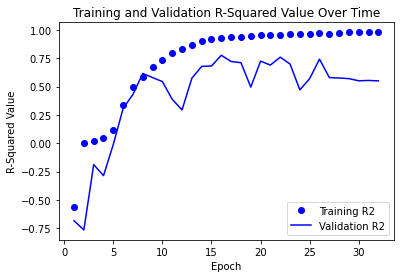

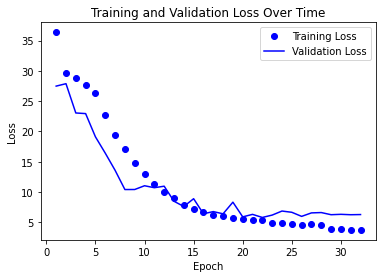

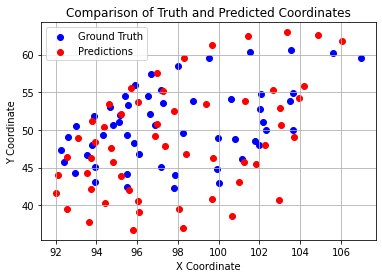

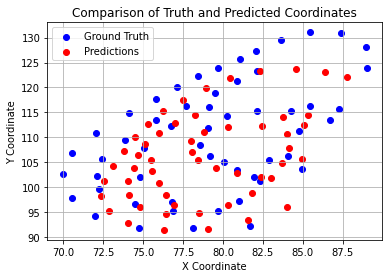

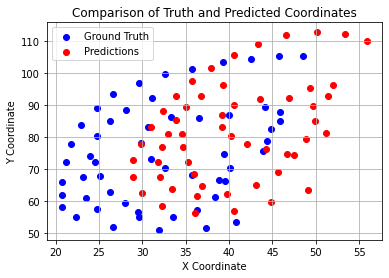

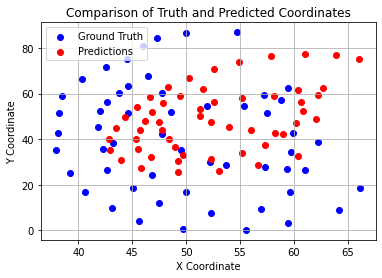

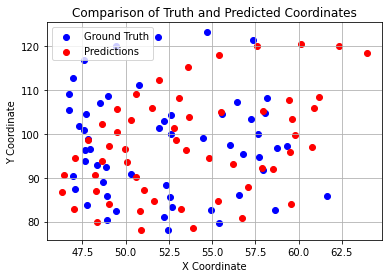

Sample 0:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


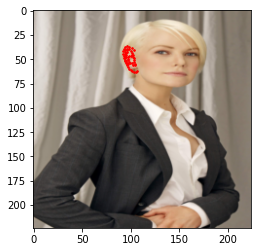

Sample 1:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


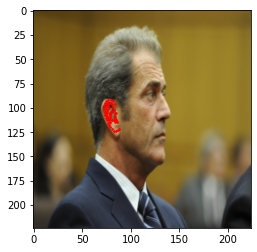

Sample 2:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


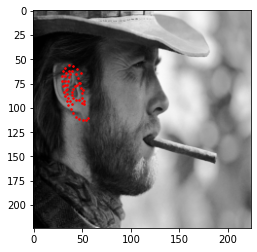

Sample 3:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


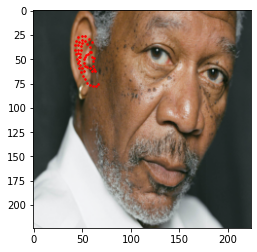

Sample 4:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


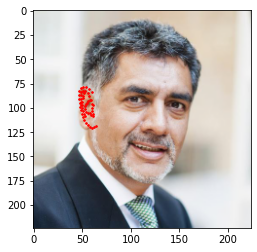

Sample 5:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


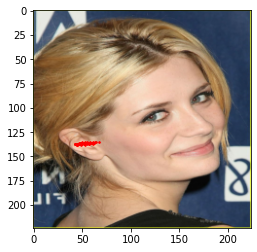

Sample 6:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


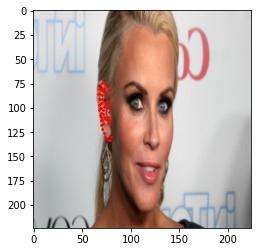

Sample 7:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


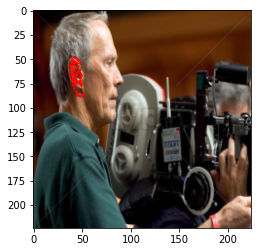

Sample 8:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


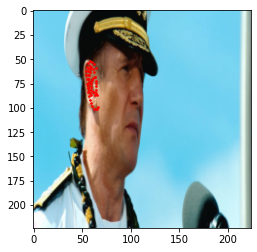

Sample 9:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


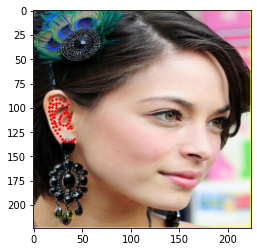

Sample 10:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


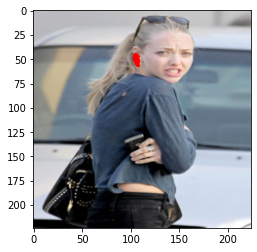

Sample 11:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


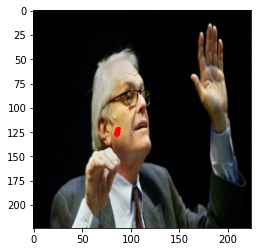

Sample 12:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


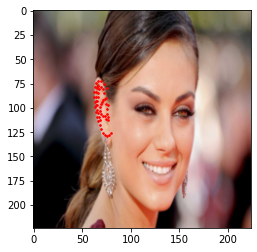

Sample 13:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


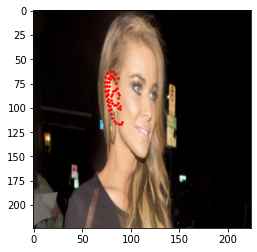

Sample 14:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


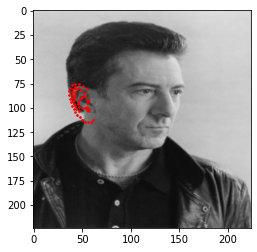

Sample 15:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


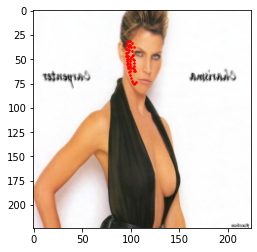

Sample 16:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


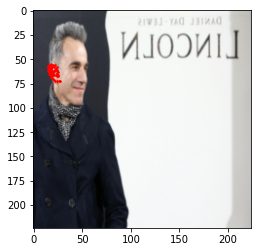

Sample 17:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


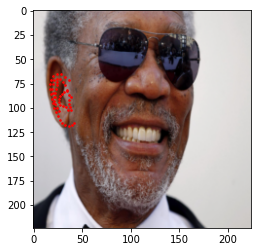

Sample 18:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


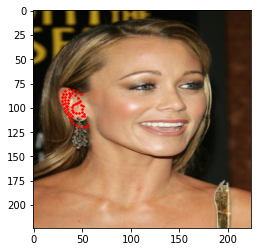

Sample 19:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


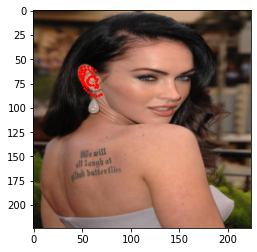

Sample 20:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


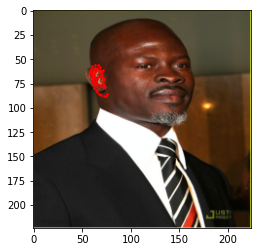

Sample 21:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


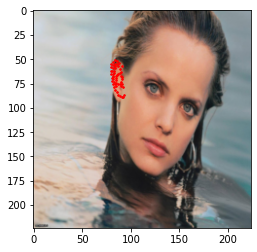

Sample 22:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


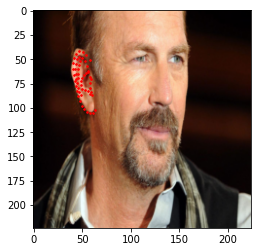

Sample 23:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


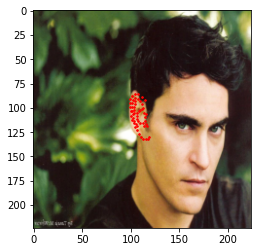

Sample 24:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


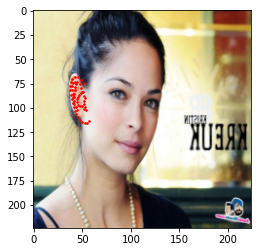

Sample 25:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


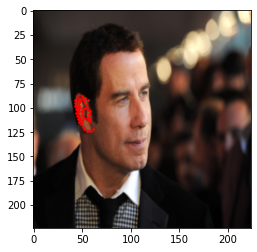

Sample 26:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


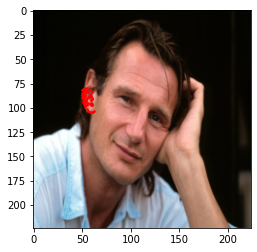

Sample 27:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


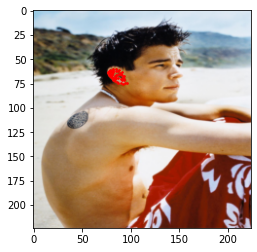

Sample 28:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


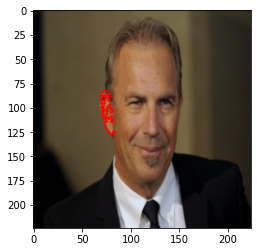

Sample 29:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


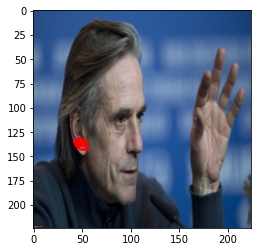

Sample 30:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


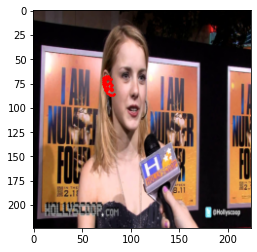

Sample 31:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


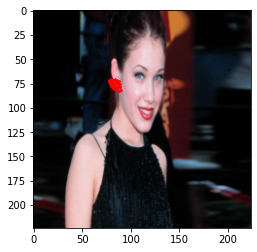

Sample 32:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


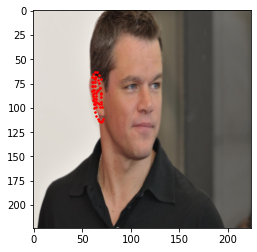

Sample 33:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


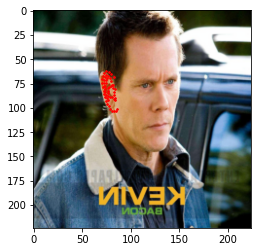

Sample 34:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


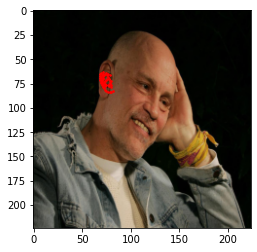

Sample 35:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


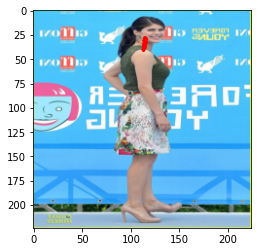

Sample 36:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


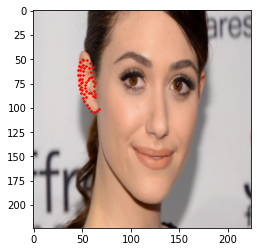

Sample 37:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


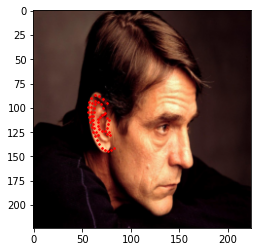

Sample 38:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


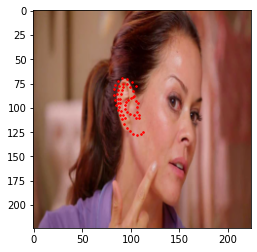

Sample 39:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


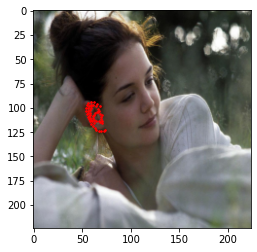

Sample 40:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


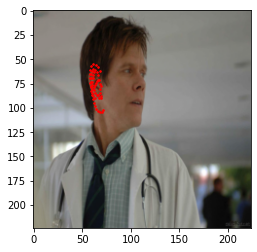

Sample 41:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


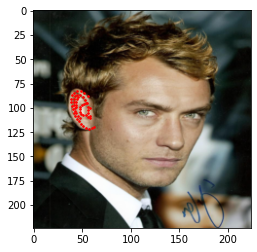

Sample 42:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


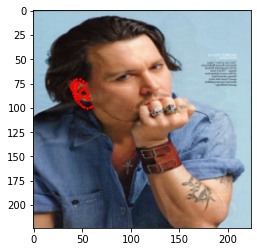

Sample 43:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


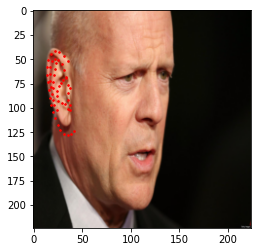

Sample 44:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


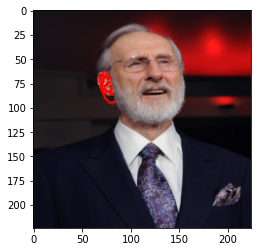

Sample 45:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


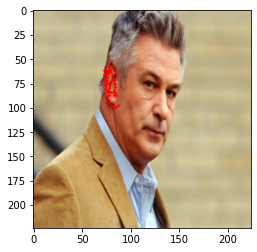

Sample 46:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


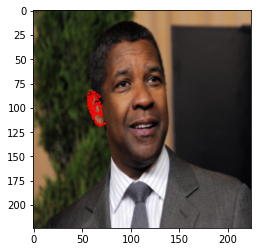

Sample 47:
Image shape: torch.Size([16, 3, 224, 224])
Landmarks shape: torch.Size([16, 55, 2])


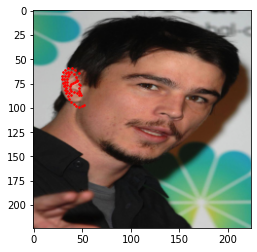

Sample 48:
Image shape: torch.Size([4, 3, 224, 224])
Landmarks shape: torch.Size([4, 55, 2])


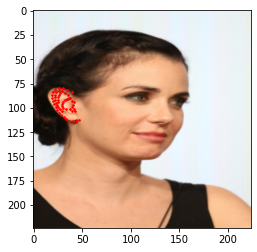

Sample 49:
Image shape: torch.Size([4, 3, 224, 224])
Landmarks shape: torch.Size([4, 55, 2])


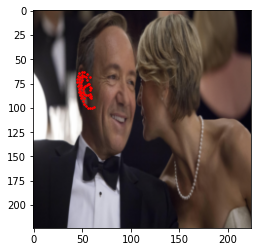

Sample 50:
Image shape: torch.Size([4, 3, 224, 224])
Landmarks shape: torch.Size([4, 55, 2])


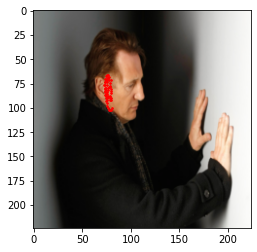

Sample 51:
Image shape: torch.Size([4, 3, 224, 224])
Landmarks shape: torch.Size([4, 55, 2])


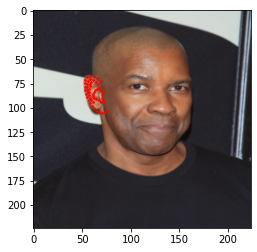

In [59]:
graph(train_result, test_result)

In [60]:
torch.save(net.state_dict(), "bohuinon_tianyech_shuweiho_final_project.h5")